### 1. CARGA DE LIBRERÍAS



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import applications
from sklearn.metrics import classification_report



### 2. ANÁLISIS EXPLORATORIO DE LOS DATOS 

#### 2.1 Distribución de clases

In [2]:
project_path = os.getcwd() #ruta donde se encuentran todos los archivos relacionados con este proyecto
train_path = os.path.join(project_path, 'Training') #ruta donde se encuentran las imágenes de entrenamiento
test_path = os.path.join(project_path, 'Testing') #ruta donde se encuentran las imágenes de test 

#Veamos si los datos están bien organizados y separados en las distintas clases
train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)

print(f"Clases encontradas en el dataset de entrenamiento: {train_classes}")
print(f"Clases encontradas en el dataset de test: {test_classes}")

Clases encontradas en el dataset de entrenamiento: ['glioma', 'meningioma', 'notumor', 'pituitary']
Clases encontradas en el dataset de test: ['glioma', 'meningioma', 'notumor', 'pituitary']


train_glioma: 1321 imágenes
test_glioma: 259 imágenes
train_meningioma: 1339 imágenes
test_meningioma: 306 imágenes
train_pituitary: 1457 imágenes
test_pituitary: 300 imágenes
train_notumor: 1595 imágenes
test_notumor: 405 imágenes


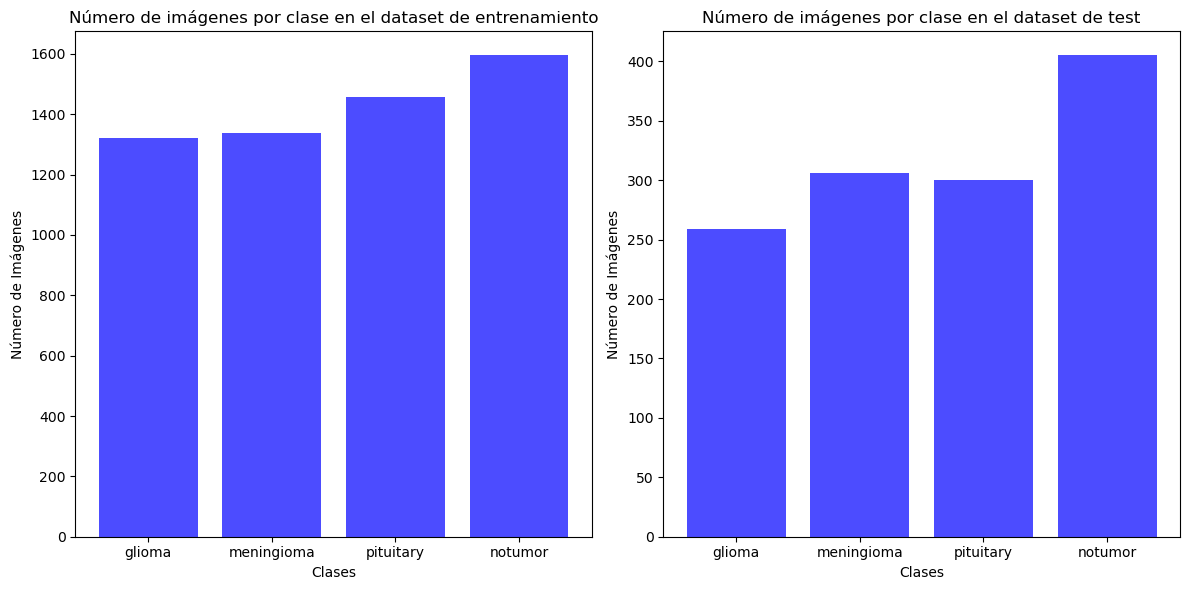

In [3]:
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

#número de imágenes por clase
train_class_num = [] 
test_class_num = []

#mostramos el número de clases de cada tipo
for class_name in classes:
    train_class_path = os.path.join(train_path, class_name)
    train_num_images = len(os.listdir(train_class_path))
    
    test_class_path = os.path.join(test_path, class_name)
    test_num_images = len(os.listdir(test_class_path))
    
    train_class_num.append(train_num_images)
    test_class_num.append(test_num_images)
    
    print(f"train_{class_name}: {train_num_images} imágenes")
    print(f"test_{class_name}: {test_num_images} imágenes")
    

    
# Crear gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de distribución en entrenamiento
axes[0].bar(classes, train_class_num, color='blue', alpha=0.7)
axes[0].set_title('Número de imágenes por clase en el dataset de entrenamiento')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Número de Imágenes')

# Gráfico de distribución en prueba
axes[1].bar(classes, test_class_num, color='blue', alpha=0.7)
axes[1].set_title('Número de imágenes por clase en el dataset de test')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Número de Imágenes')

# Ajustar visualización
plt.tight_layout()
plt.show()


#### 2.2 Visualización de imágenes

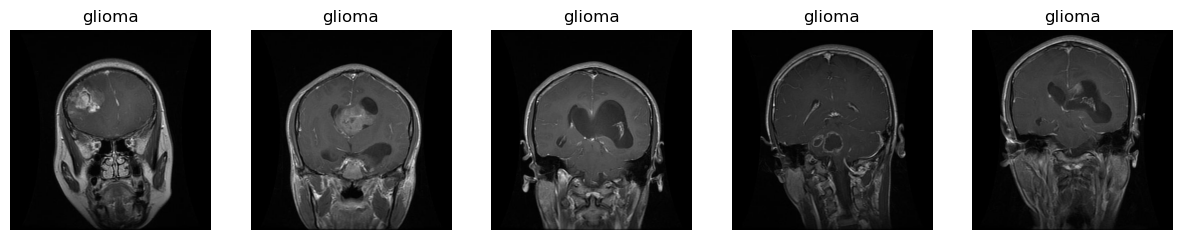

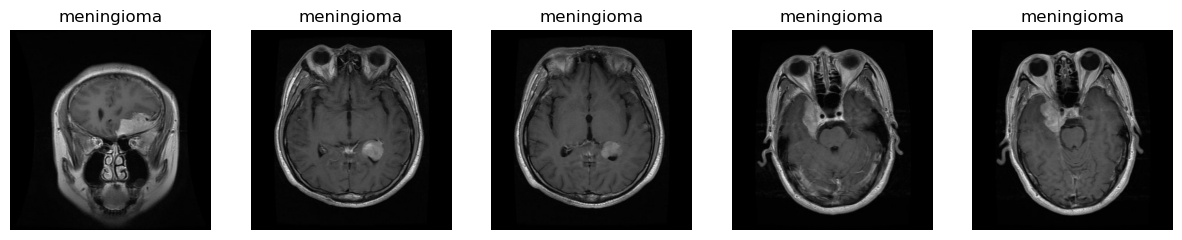

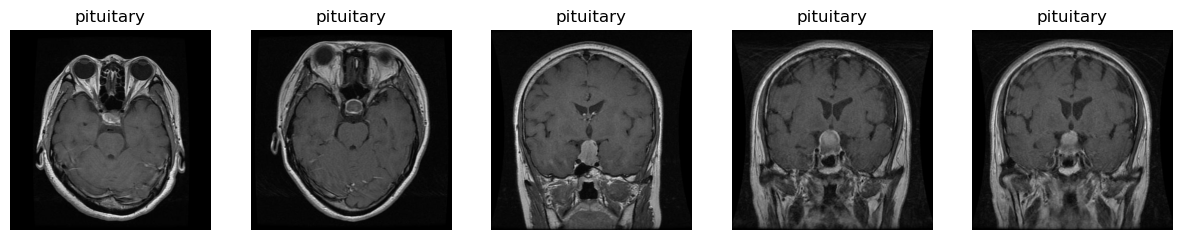

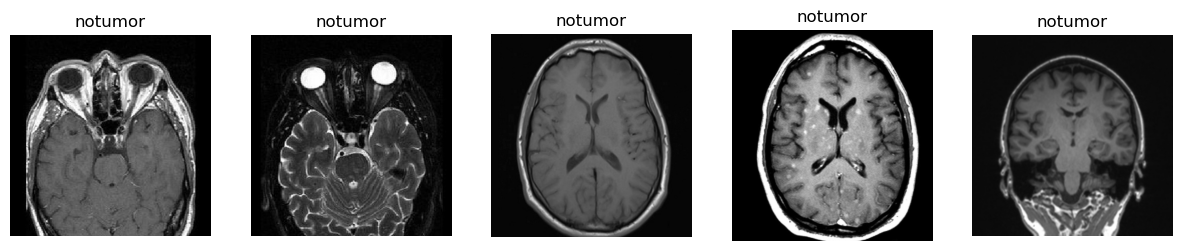

In [4]:
# Mostrar algunas imágenes de cada clase
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    images = os.listdir(class_path)[:5]  # Tomar las primeras 5 imágenes

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

### 2.3 Características de las imágenes

In [6]:
#En primer lugar vamos a inspeccionar el tamaño y el formato de todas las imágenes, tanto las de entrenamiento como las de test

train_sizes = []
train_formats = []
test_sizes = []
test_formats = []

for class_name in classes:
    train_class_path = os.path.join(train_path, class_name) 
    test_class_path = os.path.join(test_path, class_name)
    
    for image in os.listdir(train_class_path):
        img_path = os.path.join(train_class_path, image)
        img = plt.imread(img_path)
        train_sizes.append(img.shape[:2])  # (alto, ancho)
        train_formats.append(img_name.split('.')[-1])  # Extensión
        
    for image in os.listdir(test_class_path):
        img_path = os.path.join(test_class_path, image)
        img = plt.imread(img_path)
        test_sizes.append(img.shape[:2])  # (alto, ancho)
        test_formats.append(img_name.split('.')[-1])  # Extensión
    
print(f"Formatos de imagen en el dataset de entrenamiento: {set(train_formats)}")
print(f"Formatos de imagen en el dataset de test: {set(test_formats)}")
print(f"Número de dimensiones únicas en el dataset de entrenamiento: {len(set(train_sizes))}")
print(f"Número de dimensiones únicas en el dataset de test: {len(set(test_sizes))}")

     


Formatos de imagen en el dataset de entrenamiento: {'jpg'}
Formatos de imagen en el dataset de test: {'jpg'}
Número de dimensiones únicas en el dataset de entrenamiento: 382
Número de dimensiones únicas en el dataset de test: 194


### 3. PREPROCESAMIENTO DE LOS DATOS

### 3.1 Creación de los generadores de entrenamiento y test

In [5]:
#Vamos a crear un generador encargado de procesar las imágenes de entrenamiento y test para prepararlas para el modelo

def data_generator(train_path, test_path):
    #generador general
    train_data_gen = keras.preprocessing.image.ImageDataGenerator(
        rescale = 1. / 255,     #Normalización de los valores de los píxeles (entre 0 y 1)
        rotation_range = 20,    #Generación de datos sintéticos para facilitar la generalización del modelo
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.2, 
        horizontal_flip = True,
        validation_split = 0.2 #De esta forma se divide el dataset de entrenamiento en 80% entrenamiento y 20% validación
        ) 
    
    test_data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255) 

    #generadores de entrenamiento y test
    train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size = (224, 224),
        batch_size = 32,
        color_mode = 'rgb',
        class_mode = 'categorical',
        subset = 'training')
    
    val_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size = (224, 224),
        batch_size = 32,
        color_mode = 'rgb',
        class_mode = 'categorical',
        subset = 'validation')
    
    test_generator = test_data_gen.flow_from_directory(
        test_path,
        target_size = (224, 224),
        batch_size = 32,
        color_mode = 'rgb',
        class_mode = 'categorical',
        shuffle = False
)
    
    return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = data_generator(train_path, test_path)

print(f"Train: {train_generator.class_indices}")  # Ver etiquetas asignadas al conjunto de entrenamiento
print(f"Validation: {val_generator.class_indices}")  # Ver etiquetas asignadas al conjunto de validación
print(f"Test: {test_generator.class_indices}")  # Ver etiquetas asignadas al conjunto de test
    
    

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1270 images belonging to 4 classes.
Train: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Validation: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


#### 3.2 Visualización de las imágenes preprocesadas

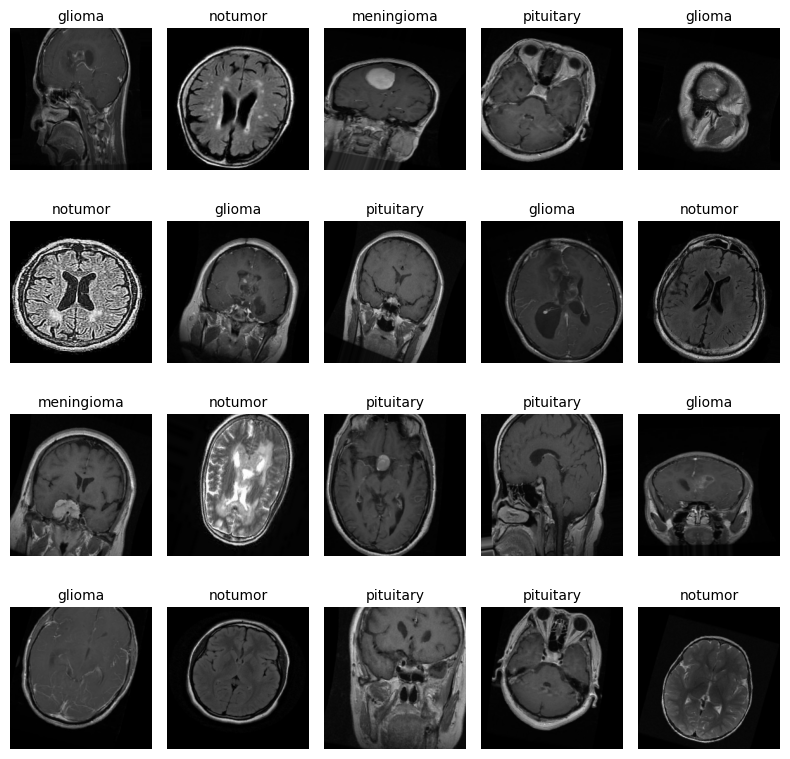

In [6]:
images, labels = next(train_generator) 

class_indices = train_generator.class_indices
class_names_dict = {v: k for k, v in class_indices.items()}
# Configurar la figura
plt.figure(figsize=(8, 8))  # Ajustar el tamaño para 5x4 imágenes

# Mostrar las primeras 20 imágenes del lote
for i in range(20):  # Mostrar 20 imágenes
    plt.subplot(4, 5, i + 1)  # Crear una grilla de 5 filas x 4 columnas
    plt.imshow(images[i])  # Mostrar cada imagen
    plt.axis('off')  # Ocultar los ejes
    plt.title(f"{class_names_dict[labels[i].argmax()]}", fontsize=10)  # Mostrar la clase con un título pequeño

plt.tight_layout()  # Ajustar la disposición
plt.show()

### 4.CONSTRUCCIÓN DEL MODELO DE RED NEURONAL CONVOLUCIONAL

### 4.1 Construcción de la red

In [44]:

def create_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()

    # Primera y segunda capa convolucional + MaxPooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Tercera y cuarta capa convolucional + MaxPooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Quinta y sexta capa convolucional + MaxPooling
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Séptima y octava capa convolucional + MaxPooling
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Novena y décima capa convolucional con 512 filtros
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten + Fully Connected
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización para evitar overfitting
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Capa de salida
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Crear el modelo
model = create_cnn()
model.summary()


c:\Users\Carlos Soler\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,420 (42.60 MB)

 Trainable params: 11,168,420 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entrenamiento del modelo

In [ ]:
#compilación del modelo
model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#monitorización
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#entrenamiento del modelo
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=val_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 780s 5s/step - accuracy: 0.3155 - loss: 1.2848 - val_accuracy: 0.4040 - val_loss: 1.4479
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - accuracy: 0.6185 - loss: 0.8505 - val_accuracy: 0.7011 - val_loss: 0.8151
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - accuracy: 0.7227 - loss: 0.6431 - val_accuracy: 0.6635 - val_loss: 0.8415
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 746s 5s/step - accuracy: 0.7789 - loss: 0.5360 - val_accuracy: 0.7108 - val_loss: 0.7166
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 734s 5s/step - accuracy: 0.8176 - loss: 0.4684 - val_accuracy: 0.7266 - val_loss: 0.7549
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 734s 5s/step - accuracy: 0.8446 - loss: 0.4265 - val_accuracy: 0.7450 - val_loss: 0.7440
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 755s 5s/step - accuracy: 0.8725 - loss: 0.3622 - val_accuracy: 0.7940 - val_loss: 0.6586
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.8768 - loss: 0.3264 - val_accu

### 4.3 Guardar el modelo y comprobar que se carga y funciona correctamente

In [46]:
model.save("models\CNN_v2.h5")

In [21]:
#Carga y desempeño en el conjunto de datos de test
cnn = models.load_model("models\CNN_v2.h5")
results = cnn.evaluate(test_generator)
loss, acc = results[0], results[1]
print(f'Accuracy del modelo en el conjunto de datos de test: {acc}')
print(f'Valor de la función de pérdidas del modelo en el conjunto de datos de test: {loss}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8614 - loss: 0.4954
Accuracy del modelo en el conjunto de datos de test: 0.9039369821548462
Valor de la función de pérdidas del modelo en el conjunto de datos de test: 0.33625414967536926


### 5. RESULTADOS DEL MODELO DE RED NEURONAL CONVOLUCIONAL

### 5.1 Accuracy y Loss function del modelo

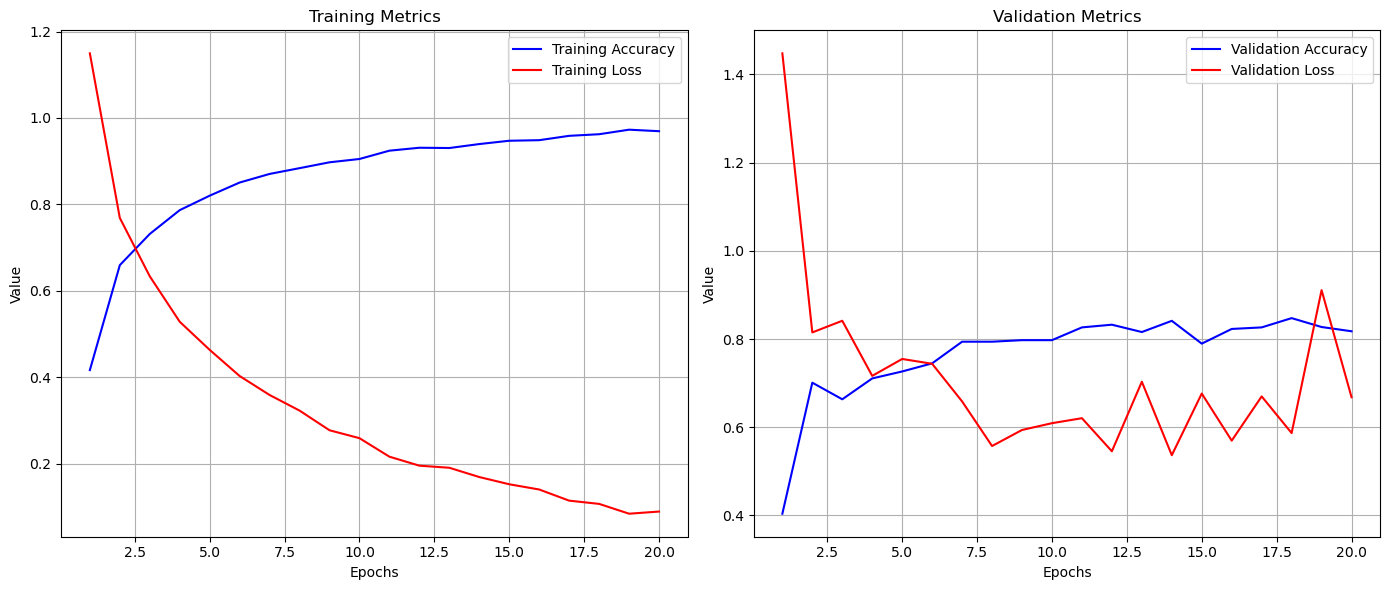

In [58]:
#Definición de variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(tr_acc) + 1)

# Crear figura y dos subplots
plt.figure(figsize=(14, 6))

# Gráfica para los datos de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, label='Training Accuracy', color='blue')
plt.plot(epochs, tr_loss, label='Training Loss', color='red')
plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Gráfica para los datos de validación
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()


### 5.2 Matriz de confusión

40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
      Real  Predicción
0        0           0
1        0           0
2        0           0
3        0           1
4        0           1
...    ...         ...
1265     3           3
1266     3           3
1267     3           3
1268     3           3
1269     3           3

[1270 rows x 2 columns]
[[235  23   0   1]
 [ 21 217  39  29]
 [  2   3 400   0]
 [  1   3   0 296]]


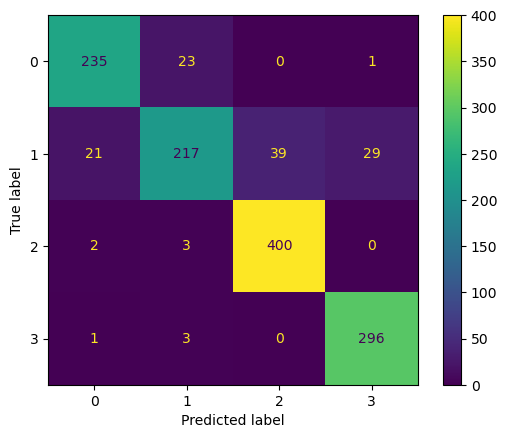

In [22]:
predictions = cnn.predict(test_generator)
true_labels = test_generator.classes
prediction_labels = np.argmax(predictions, axis = 1)

# Calcular matriz de confusión
cm = confusion_matrix(true_labels, prediction_labels)

df_results = pd.DataFrame({
    'Real': true_labels,
    'Predicción': prediction_labels
})
print(df_results)
print(cm)

#Dibujamos la matriz de confusión como un mapa de calor
conf_mat = ConfusionMatrixDisplay(cm)
conf_mat.plot()



### 5.3 Informe de resultados del modelo

In [23]:
# Obtener las clases del generador
class_names = list(test_generator.class_indices.keys())

# Generar el informe
report = classification_report(true_labels, prediction_labels, target_names=class_names)

print(report)


              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91       259
  meningioma       0.88      0.71      0.79       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.90      1270
   macro avg       0.90      0.90      0.90      1270
weighted avg       0.90      0.90      0.90      1270



### 5.4 Curva ROC y métricas AUC

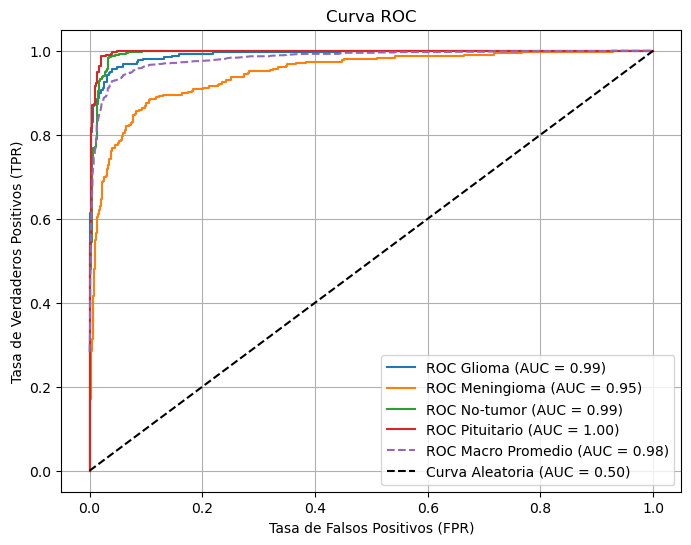

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Número de clases en el dataset
num_classes = predictions.shape[1]  # Asume que predictions ya es una matriz (n_samples, num_classes)

# Asegurarse de que las etiquetas verdaderas estén en formato one-hot
if len(true_labels.shape) == 1:  # Si están en formato categórico (ejemplo: [0, 1, 2, ...])
    true_labels = label_binarize(true_labels, classes=np.arange(num_classes))

# Inicialización de diccionarios para almacenar los resultados por clase
fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC para cada clase

# Cálculo de FPR, TPR y AUC para cada clase
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Cálculo de la curva ROC macro-promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))

# Curvas ROC para cada clase
for i in range(num_classes):
    if i == 0:
        plt.plot(fpr[i], tpr[i], label=f'ROC Glioma (AUC = {roc_auc[i]:.2f})')
    elif i == 1:
        plt.plot(fpr[i], tpr[i], label=f'ROC Meningioma (AUC = {roc_auc[i]:.2f})')
    elif i == 2:
        plt.plot(fpr[i], tpr[i], label=f'ROC No-tumor (AUC = {roc_auc[i]:.2f})')
    else:
        plt.plot(fpr[i], tpr[i], label=f'ROC Pituitario (AUC = {roc_auc[i]:.2f})')

# Curva ROC promedio (macro)
plt.plot(fpr["macro"], tpr["macro"], label=f'ROC Macro Promedio (AUC = {roc_auc["macro"]:.2f})', linestyle='--')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='Curva Aleatoria (AUC = 0.50)')

# Personalización del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### 6. TRANFER LEARNING UTILIZANDO EL MODELO VGG16

### 6.1 Construcción del modelo

In [6]:

# Cargar modelo preentrenado VGG16
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas iniciales
for layer in base_model.layers:
   layer.trainable = False

# Añadir capas personalizadas
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x) 
tl_model = models.Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
tl_model.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Monitorización
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)



### 6.2 Entrenamiento del modelo

In [7]:
# Entrenar el modelo
history = tl_model.fit(train_generator, 
                    epochs=15, 
                    validation_data=val_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping, reduce_lr])

c:\Users\Carlos Soler\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1105s 8s/step - accuracy: 0.7021 - loss: 0.8400 - val_accuracy: 0.7695 - val_loss: 0.6218 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1014s 7s/step - accuracy: 0.9040 - loss: 0.2564 - val_accuracy: 0.8011 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1755s 12s/step - accuracy: 0.9324 - loss: 0.1821 - val_accuracy: 0.8072 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1011s 7s/step - accuracy: 0.9420 - loss: 0.1565 - val_accuracy: 0.8414 - val_loss: 0.4828 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1001s 7s/step - accuracy: 0.9555 - loss: 0.1191 - val_accuracy: 0.8370 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1000s 7s/step - accuracy: 0.9617 - loss: 0.1067 - val_accuracy: 0.8493 - val_loss: 0.5038 - learning_rate: 1.0000e-04
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1026s 7s/st

### 6.3 Guardar el modelo y comprobar que se carga y funciona correctamente

In [8]:
tl_model.save("models/VGG16.h5")

In [27]:
#Carga y desempeño en el conjunto de datos de test

tl_vgg = models.load_model("models\VGG16.h5")
results = tl_vgg.evaluate(test_generator)
loss, acc = results[0], results[1]
print(f'Accuracy del modelo en el conjunto de datos de test: {acc}')
print(f'Valor de la función de pérdidas del modelo en el conjunto de datos de test: {loss}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.8635 - loss: 0.3812
Accuracy del modelo en el conjunto de datos de test: 0.9047244191169739
Valor de la función de pérdidas del modelo en el conjunto de datos de test: 0.2766946256160736


### 6.4 Matriz de confusión del modelo de transfer learning

      Real  Predicción
0        0           0
1        0           1
2        0           0
3        0           1
4        0           1
...    ...         ...
1265     3           3
1266     3           3
1267     3           3
1268     3           3
1269     3           3

[1270 rows x 2 columns]
[[227  31   0   1]
 [ 20 234  14  38]
 [  3   8 391   3]
 [  0   3   0 297]]


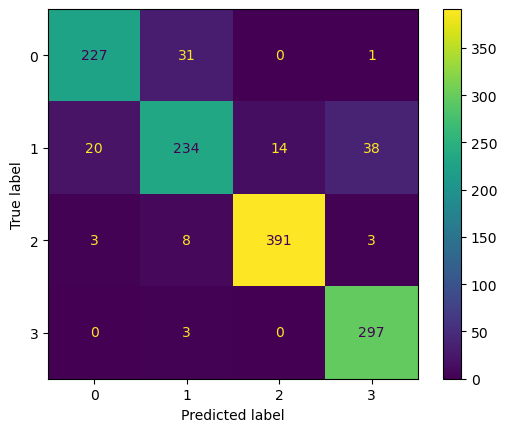

In [18]:
predictions = tl_vgg.predict(test_generator)
true_labels = test_generator.classes
prediction_labels = np.argmax(predictions, axis = 1)

# Calcular matriz de confusión
cm = confusion_matrix(true_labels, prediction_labels)

df_results = pd.DataFrame({
    'Real': true_labels,
    'Predicción': prediction_labels
})
print(df_results)
print(cm)

#Dibujamos la matriz de confusión como un mapa de calor
conf_mat = ConfusionMatrixDisplay(cm)
conf_mat.plot()



### 6.5 Informe de resultados del modelo de transfer learning

In [19]:
# Obtener las clases del generador
class_names = list(test_generator.class_indices.keys())

# Generar el informe
report = classification_report(true_labels, prediction_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

      glioma       0.91      0.88      0.89       259
  meningioma       0.85      0.76      0.80       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.88      0.99      0.93       300

    accuracy                           0.90      1270
   macro avg       0.90      0.90      0.90      1270
weighted avg       0.90      0.90      0.90      1270



### 6.6 Curva ROC y métricas AUC

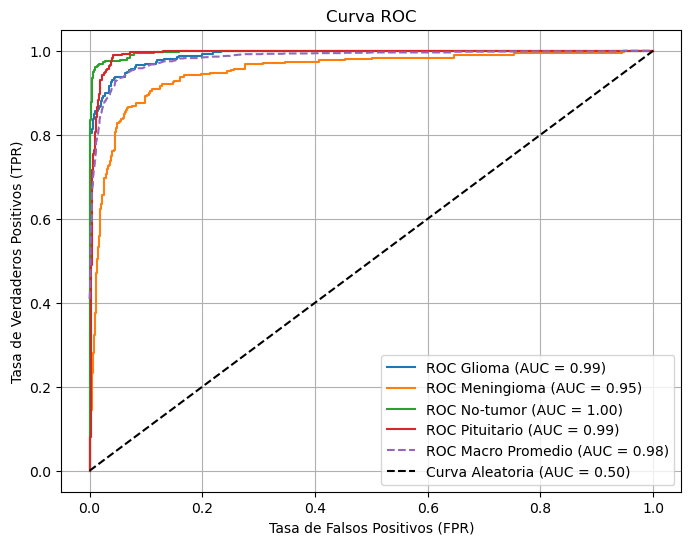

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Número de clases en el dataset
num_classes = predictions.shape[1]  # Asume que predictions ya es una matriz (n_samples, num_classes)

# Asegurarse de que las etiquetas verdaderas estén en formato one-hot
if len(true_labels.shape) == 1:  # Si están en formato categórico (ejemplo: [0, 1, 2, ...])
    true_labels = label_binarize(true_labels, classes=np.arange(num_classes))

# Inicialización de diccionarios para almacenar los resultados por clase
fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC para cada clase

# Cálculo de FPR, TPR y AUC para cada clase
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Cálculo de la curva ROC macro-promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))

# Curvas ROC para cada clase
for i in range(num_classes):
    if i == 0:
        plt.plot(fpr[i], tpr[i], label=f'ROC Glioma (AUC = {roc_auc[i]:.2f})')
    elif i == 1:
        plt.plot(fpr[i], tpr[i], label=f'ROC Meningioma (AUC = {roc_auc[i]:.2f})')
    elif i == 2:
        plt.plot(fpr[i], tpr[i], label=f'ROC No-tumor (AUC = {roc_auc[i]:.2f})')
    else:
        plt.plot(fpr[i], tpr[i], label=f'ROC Pituitario (AUC = {roc_auc[i]:.2f})')

# Curva ROC promedio (macro)
plt.plot(fpr["macro"], tpr["macro"], label=f'ROC Macro Promedio (AUC = {roc_auc["macro"]:.2f})', linestyle='--')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='Curva Aleatoria (AUC = 0.50)')

# Personalización del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### 6.7 Fine Tuning

In [5]:

# Cargar modelo preentrenado VGG16
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:15]:  # Congelar solo las 15 primeras capas
    layer.trainable = False
for layer in base_model.layers[15:]:  # Descongelar las últimas capas
    layer.trainable = True


# Añadir capas personalizadas
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x) 
ftun_model = models.Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
ftun_model.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Monitorización
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)



In [11]:
# Entrenar el modelo
history = ftun_model.fit(train_generator, 
                    epochs=7, 
                    validation_data=val_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1274s 9s/step - accuracy: 0.9858 - loss: 0.0441 - val_accuracy: 0.8791 - val_loss: 0.6030 - learning_rate: 1.0000e-04
Epoch 2/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1292s 9s/step - accuracy: 0.9851 - loss: 0.0433 - val_accuracy: 0.8869 - val_loss: 0.4636 - learning_rate: 1.0000e-04
Epoch 3/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1250s 9s/step - accuracy: 0.9901 - loss: 0.0270 - val_accuracy: 0.8957 - val_loss: 0.5104 - learning_rate: 1.0000e-04
Epoch 4/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1172s 8s/step - accuracy: 0.9985 - loss: 0.0079 - val_accuracy: 0.8720 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 5/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1170s 8s/step - accuracy: 0.9939 - loss: 0.0197 - val_accuracy: 0.8466 - val_loss: 0.5288 - learning_rate: 1.0000e-04
Epoch 6/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1182s 8s/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.8826 - val_loss: 0.5557 - learning_rate: 1.0000e-04
Epoch 7/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 1170s 8s/step - acc

In [12]:
#ftun_model.save("models/VGG16_fine_tuning.h5")

In [7]:
ftun_model = models.load_model("models\VGG16_fine_tuning.h5")
ftun_model.evaluate(test_generator)

c:\Users\Carlos Soler\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 241s 6s/step - accuracy: 0.9070 - loss: 0.3070


[0.21279871463775635, 0.9409449100494385]

40/40 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step
      Real  Predicción
0        0           0
1        0           1
2        0           1
3        0           1
4        0           1
...    ...         ...
1265     3           3
1266     3           3
1267     3           3
1268     3           3
1269     3           3

[1270 rows x 2 columns]
[[232  27   0   0]
 [  9 275   5  17]
 [  4   7 394   0]
 [  2   4   0 294]]


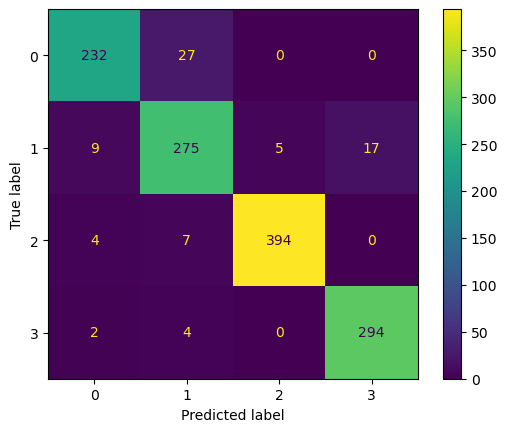

In [8]:
predictions = ftun_model.predict(test_generator)

true_labels = test_generator.classes
prediction_labels = np.argmax(predictions, axis = 1)

# Calcular matriz de confusión
cm = confusion_matrix(true_labels, prediction_labels)

df_results = pd.DataFrame({
    'Real': true_labels,
    'Predicción': prediction_labels
})
print(df_results)
print(cm)

#Dibujamos la matriz de confusión como un mapa de calor
conf_mat = ConfusionMatrixDisplay(cm)
conf_mat.plot()

In [9]:
# Obtener las clases del generador
class_names = list(test_generator.class_indices.keys())

# Generar el informe
report = classification_report(true_labels, prediction_labels, target_names=class_names)

print(report)

              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       259
  meningioma       0.88      0.90      0.89       306
     notumor       0.99      0.97      0.98       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.94      1270
   macro avg       0.94      0.94      0.94      1270
weighted avg       0.94      0.94      0.94      1270



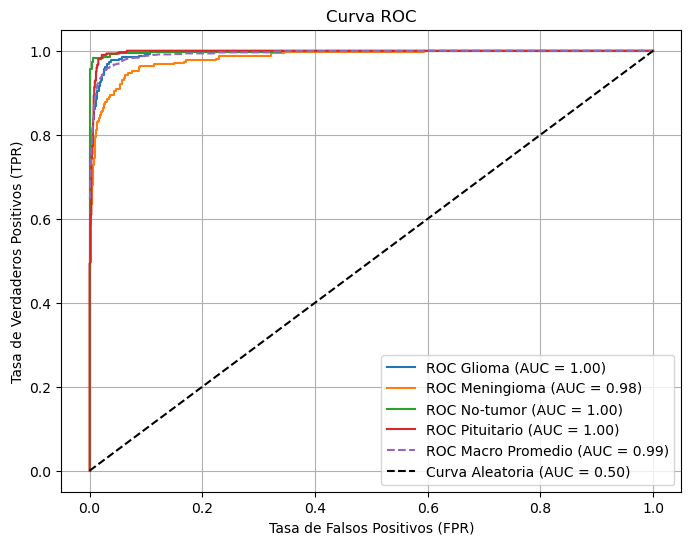

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Número de clases en el dataset
num_classes = predictions.shape[1]  # Asume que predictions ya es una matriz (n_samples, num_classes)

# Asegurarse de que las etiquetas verdaderas estén en formato one-hot
if len(true_labels.shape) == 1:  # Si están en formato categórico (ejemplo: [0, 1, 2, ...])
    true_labels = label_binarize(true_labels, classes=np.arange(num_classes))

# Inicialización de diccionarios para almacenar los resultados por clase
fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC para cada clase

# Cálculo de FPR, TPR y AUC para cada clase
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Cálculo de la curva ROC macro-promedio
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))

# Curvas ROC para cada clase
for i in range(num_classes):
    if i == 0:
        plt.plot(fpr[i], tpr[i], label=f'ROC Glioma (AUC = {roc_auc[i]:.2f})')
    elif i == 1:
        plt.plot(fpr[i], tpr[i], label=f'ROC Meningioma (AUC = {roc_auc[i]:.2f})')
    elif i == 2:
        plt.plot(fpr[i], tpr[i], label=f'ROC No-tumor (AUC = {roc_auc[i]:.2f})')
    else:
        plt.plot(fpr[i], tpr[i], label=f'ROC Pituitario (AUC = {roc_auc[i]:.2f})')

# Curva ROC promedio (macro)
plt.plot(fpr["macro"], tpr["macro"], label=f'ROC Macro Promedio (AUC = {roc_auc["macro"]:.2f})', linestyle='--')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='Curva Aleatoria (AUC = 0.50)')

# Personalización del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()
